In [ ]:
!pip install bitstring

In [3]:
import pickle
import numpy as np

from itertools import product
from bitstring import BitArray, Bits, BitStream

from sklearn.datasets import load_sample_image
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

### Código Auxiliar

In [4]:
class MyImgFormat:
    def __init__(self, mat_rgb_ids, rgb_ids_dict):
        self.im_shape_      = mat_rgb_ids.shape
        self.rgb_ids_dict_  = rgb_ids_dict
        self.num_bits_uint_ = int(np.ceil(np.log2(len(rgb_ids_dict))))
        
        self._mat2bytes(mat_rgb_ids)
        
    def _mat2bytes(self, mat):
        self.pixel_bytes_ = BitStream()
        
        pixel_rgb_ids = mat.reshape(-1)
        for rgb_id in pixel_rgb_ids:
            self.pixel_bytes_.append(Bits(uint=int(rgb_id), length=self.num_bits_uint_))
        
    def unpack(self):
        # unpack IDs
        cp_bits = self.pixel_bytes_.copy()
        num_ids = cp_bits.len // self.num_bits_uint_
        
        mat_ids = np.array([
            cp_bits.read('uint:%d' % (self.num_bits_uint_))\
            for i in range(num_ids)\
        ]).reshape(self.im_shape_)
        
        # unpack RGB
        im_rgb = np.zeros((self.im_shape_[0], self.im_shape_[1], 3), dtype='uint8')
        for i in range(self.im_shape_[0]):
            for j in range(self.im_shape_[1]):
                im_rgb[i, j, :] = self.rgb_ids_dict_[mat_ids[i, j]]
                
        return im_rgb

In [5]:
def uniform_quant(im, n_colors):
    # numero de cores e espaco entre as cores (lagura do bin)
    n_vals_ch  = int(np.cbrt(n_colors))
    bin_size   = 256 // n_vals_ch
    
    # possiveis valores por canal e por pixel (combinacao dos 3 canais)
    ch_vals    = np.uint8((np.arange(n_vals_ch)) * bin_size)
    pixel_vals = list(product(ch_vals, ch_vals, ch_vals))
    
    im_qt_rgb  = im // bin_size
    im_qt_rgb[im_qt_rgb >= n_vals_ch] = n_vals_ch - 1
    im_qt_rgb  = np.uint8((im_qt_rgb) * bin_size)
    
    # criar os dicionarios ID -> pixel e pixel -> ID
    dict_id2pixel = {i: list(pixel_vals[i]) for i in range(len(pixel_vals))}
    dict_pixel2id = {pixel_vals[i]: i for i in range(len(pixel_vals))}
    
    mat_ids = np.zeros((im.shape[0], im.shape[1]), dtype='uint8')
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            mat_ids[i, j] = dict_pixel2id[tuple(im_qt_rgb[i, j])]
    
    return mat_ids, dict_id2pixel

In [6]:
def get_bin_size_kb(obj):
    return len(pickle.dumps(obj)) / 1e3

In [7]:
img_china = load_sample_image('china.jpg')
img_flower = load_sample_image('flower.jpg')

# Exercicio 1

In [8]:
def uniform_quant_mod(im, n_colors):
    # numero de cores e espaco entre as cores (lagura do bin)
    n_vals_ch  = int(np.cbrt(n_colors))
    bin_size   = 256 // n_vals_ch
    
    # possiveis valores por canal e por pixel (combinacao dos 3 canais)
    ch_vals    = np.uint8((np.arange(n_vals_ch) * bin_size) + bin_size//2)
    pixel_vals = list(product(ch_vals, ch_vals, ch_vals))
    
    im_qt_rgb  = im // bin_size
    im_qt_rgb[im_qt_rgb >= n_vals_ch] = n_vals_ch - 1
    im_qt_rgb  = np.uint8(((im_qt_rgb) * bin_size) + bin_size//2)
    
    # criar os dicionarios ID -> pixel e pixel -> ID
    dict_id2pixel = {i: list(pixel_vals[i]) for i in range(len(pixel_vals))}
    dict_pixel2id = {pixel_vals[i]: i for i in range(len(pixel_vals))}
    
    mat_ids = np.zeros((im.shape[0], im.shape[1]), dtype='uint8')
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            mat_ids[i, j] = dict_pixel2id[tuple(im_qt_rgb[i, j])]
    
    return mat_ids, dict_id2pixel

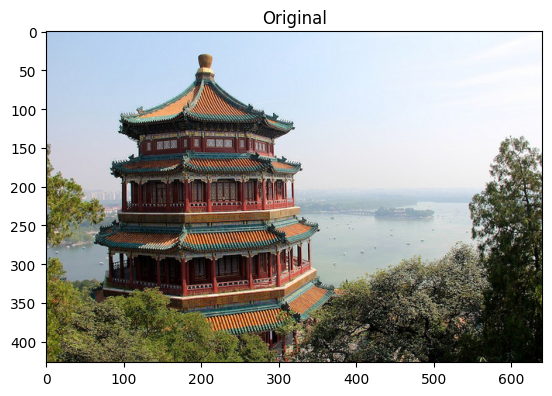

In [9]:
plt.imshow(img_china)
plt.title("Original")
plt.show()

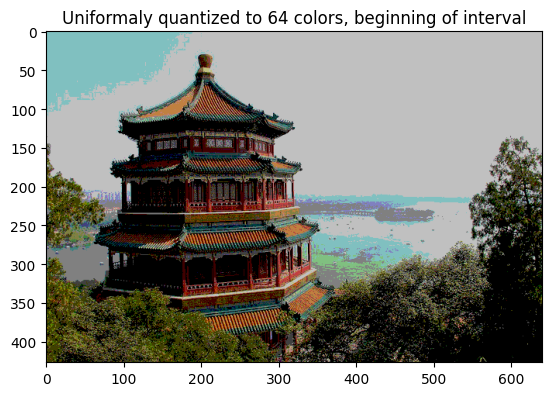

In [10]:
id, dic = uniform_quant(img_china, 64)
img_quant_f = MyImgFormat(id, dic)

plt.imshow(img_quant_f.unpack())
plt.title("Uniformaly quantized to 64 colors, beginning of interval")
plt.show()

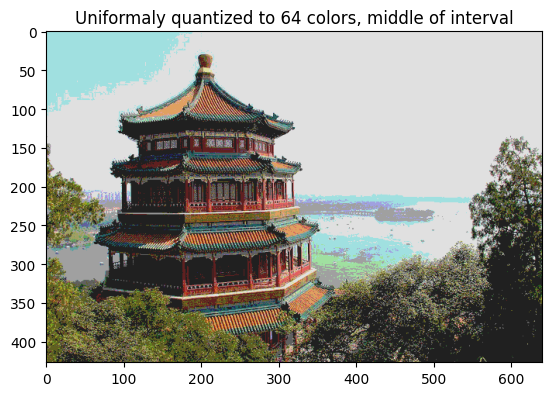

In [11]:
id_mod, dic_mod = uniform_quant_mod(img_china, 64)
img_quant_mod_f = MyImgFormat(id_mod, dic_mod)

plt.imshow(img_quant_mod_f.unpack())
plt.title("Uniformaly quantized to 64 colors, middle of interval")
plt.show()

A quantização uniforme usando os valores do meio do itervalo gerou cores menos vibrantes que a quantização uniforme usando valores do inicio do intervalo

In [12]:
print(f'Original image\'s size: {get_bin_size_kb(img_china)}')
print(f'Uniformaly quantized with interval\'s start image\'s size: {get_bin_size_kb(img_quant_f)}')
print(f'Uniformaly quantized with interval\'s middle image\'s size: {get_bin_size_kb(img_quant_mod_f)}')

Original image's size: 820.005
Uniformaly quantized with interval's start image's size: 206.207
Uniformaly quantized with interval's middle image's size: 206.207


Percebe-se que as imagens quantizadas tem menor tamanho que a imagem original. Além disso, como ambas as quantizações usam o mesmo número de cores, geram imagens com o mesmo tamanho.

# Exercicio 2

In [13]:
def k_means_quant(img, n_colors):

  X = img.reshape((-1, 3))

  kmeans = KMeans(
      n_clusters=n_colors,
      max_iter=10,
      random_state=42,
      n_init=10
  )

  kmeans.fit(X)
  clusters = kmeans.predict(X)
  mat_ids = clusters.reshape(img.shape[:2])
  dict_id2pixel = {i: list(np.uint8(kmeans.cluster_centers_[i])) for i in range(n_colors)}
  
  return mat_ids, dict_id2pixel

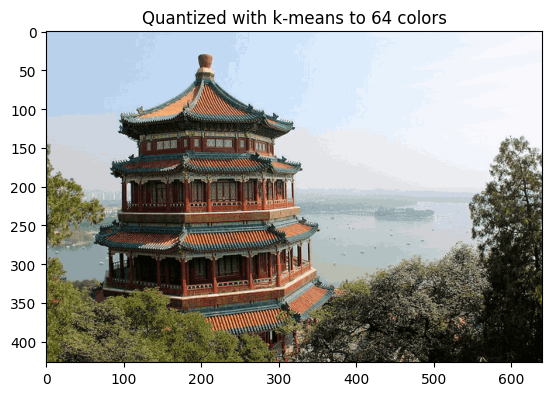

In [14]:
id, dic = k_means_quant(img_china, 64)
img_kmeans_f = MyImgFormat(id, dic)

plt.imshow(img_kmeans_f.unpack())
plt.title("Quantized with k-means to 64 colors")
plt.show()

Percebe-se que a quantização usando o kmeans gerou uma imagem com transições mais suaves, principalmente nos tons azulados do fundo da paisagem. As cores, como na quantização uniforme com valores do meio do intervalo, são mais brandas que as da quantização uniforme com valores no começo do intervalo. Os tons laranjas e vermelhos da construção ficaram mais similares uns com os outros do que nas quantizações uniformes. De mesmo modo, os tons verdes da vegetação aparentam estar mais próximos do que nas quantizações uniformes, prinicipalmente do que na de valores no inicio do intervalo. Portanto, percebe-se que a quantização usando o método kmeans gerou mais cores de tons azulados e menos de outros tons, quando comparada às quantizações uniformes. Isso reflete-se na maior suavidade no fundo da paisagem e, menos perceptivelmente, perda de distinção dos outros tons.

Essa diferença entre os métodos é ainda mai

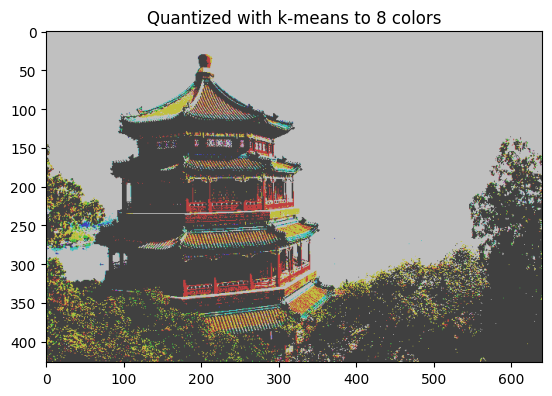

In [45]:
id, dic = uniform_quant_mod(img_china, 8)
img_kmeans_f = MyImgFormat(id, dic)

plt.imshow(img_kmeans_f.unpack())
plt.title("Quantized with k-means to 8 colors")
plt.show()

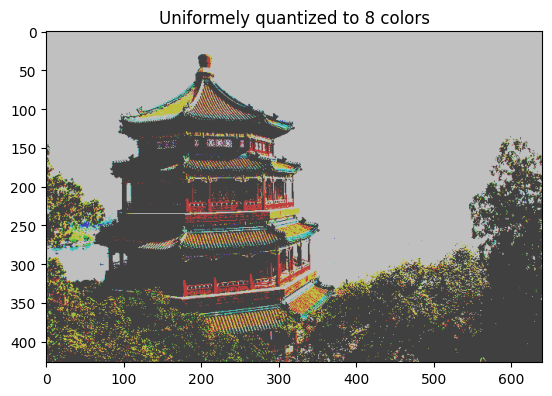

In [18]:
id, dic = uniform_quant_mod(img_china, 8)
img_kmeans_f = MyImgFormat(id, dic)

plt.imshow(img_kmeans_f.unpack())
plt.title("Uniformely quantized to 8 colors")
plt.show()

# Exercicio 3

In [52]:
def k_means_quant_inertia(img, n_colors):

  X = img.reshape((-1, 3))

  kmeans = KMeans(
      n_clusters=n_colors,
      max_iter=10,
      random_state=42,
      n_init=10
  )

  kmeans.fit(X)
  clusters = kmeans.predict(X)
  mat_ids = clusters.reshape(img.shape[:2])
  dict_id2pixel = {i: list(np.uint8(kmeans.cluster_centers_[i])) for i in range(n_colors)}

  inertia = 0
  for i in range(img.shape[0]):
      for j in range(img.shape[1]):
          cluster_id = mat_ids[i, j]
          for k in range(3):
            inertia += (img[i,j,k] - kmeans.cluster_centers_[cluster_id][k])**2

  return mat_ids, dict_id2pixel, inertia

In [20]:
def mse_calc(orig_img, quant_img):
  mse = 0
  for i in range(orig_img.shape[0]):
    for j in range(orig_img.shape[1]):
      for k in range(3):
        mse += (int(orig_img[i,j,k]) - int(quant_img[i,j,k]))**2
  mse = mse/(orig_img.shape[0]*orig_img.shape[1]*3)
  return mse

In [54]:
id, dic, inertia = k_means_quant_inertia(img_china, 64)
print(f'Kmeans\' Inertia : {round(inertia,2)}')
img_kmeans_f = MyImgFormat(id, dic)

Kmeans' Inertia : 30958883.96


In [55]:
mse = mse_calc(img_china, img_kmeans_f.unpack())
print(f'MSE between pixels of the original image and of the quantized with kmeans: {round(mse,2)}')

MSE between pixels of the original image and of the quantized with kmeans: 38.11


# Exercicio 4

In [22]:
def quantize_img(img, ks):
  imgs_kmeans_f = []
  inertias = []
  imgs_uni_f = []

  for k in ks:
    id, dic = uniform_quant_mod(img, k)
    imgs_uni_f.append(MyImgFormat(id, dic))

    id, dic, inertia = k_means_quant_inertia(img, k)
    inertias.append(inertia)
    imgs_kmeans_f.append(MyImgFormat(id, dic))

  return imgs_uni_f, imgs_kmeans_f, inertias

In [23]:
def plot_inertias(inertias, ks, title):
  plt.plot(ks, inertias, 'bx-')
  plt.title(title)
  plt.xlabel('colors')
  plt.ylabel('Inertia')
  plt.show()

In [24]:
def calc_and_plot_mse(img_origin, imgs_f, ks, title):
  mses = []
  for i in range(len(imgs_f)):
    mses.append(mse_calc(img_origin, imgs_f[i].unpack()))

  plt.plot(ks, mses, 'bx-')
  plt.title(title)
  plt.xlabel('colors')
  plt.ylabel('MSE')
  plt.show()

In [25]:
def calc_and_plot_size(img_origin, imgs_f, ks, title):
  sizes = []
  print(type(imgs_f))
  for i in range(len(imgs_f)):
    sizes.append(get_bin_size_kb(imgs_f[i]))

  plt.plot(ks, sizes, 'bx-')
  plt.title(title + f" (original size = {get_bin_size_kb(img_origin)} kb)")
  plt.xlabel('colors')
  plt.ylabel('Size (kb)')
  plt.show()

In [26]:
def plot_images(imgs_f, ks, title):
  
  for i in range(len(imgs_f)):
    plt.imshow(imgs_f[i].unpack())
    plt.title(title + f' quantization with {ks[i]} colors')
    plt.show()

In [27]:
ks = [8, 27, 64, 125, 216]

In [28]:
china_imgs_uni_f, china_imgs_kmeans_f, china_inertias = quantize_img(img_china, ks)

In [29]:
flower_imgs_uni_f, flower_imgs_kmeans_f, flower_inertias = quantize_img(img_flower, ks)

## Imagens geradas

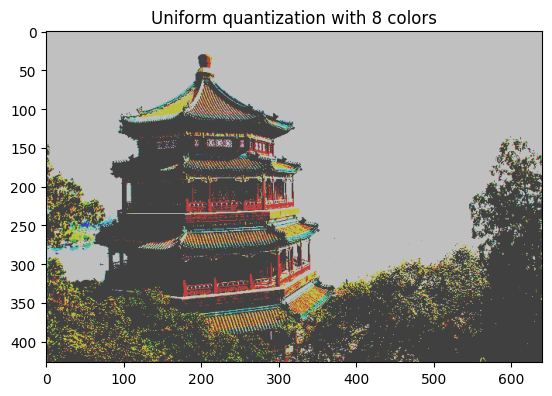

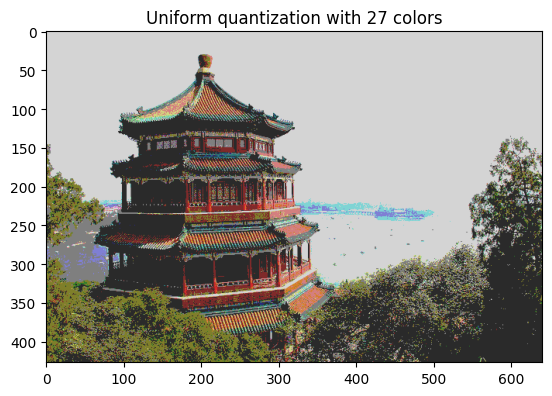

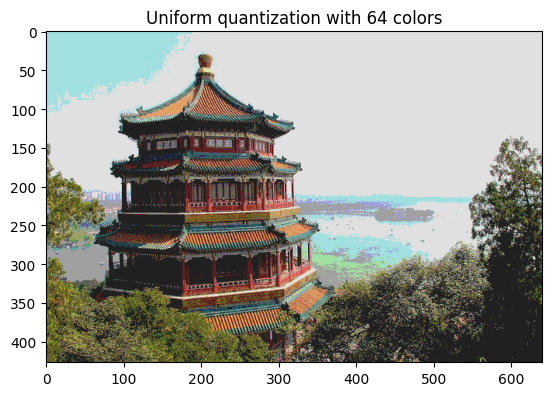

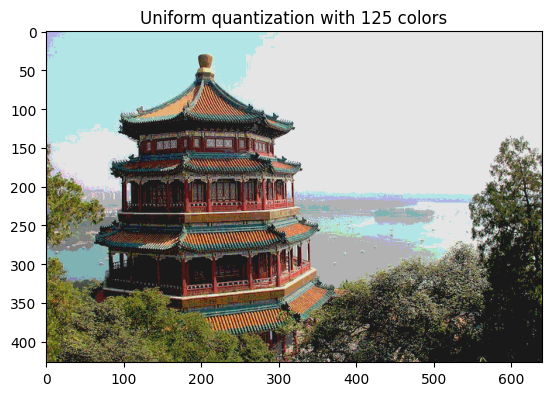

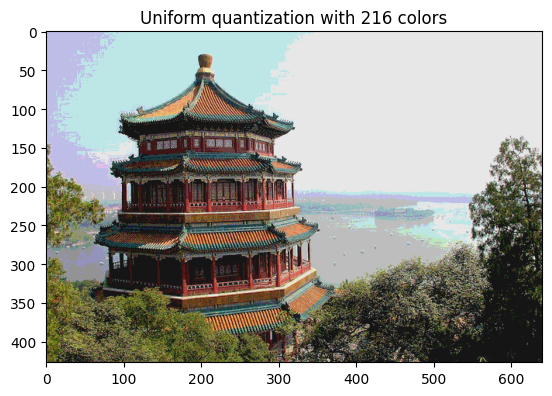

In [30]:
plot_images(china_imgs_uni_f, ks, 'Uniform')

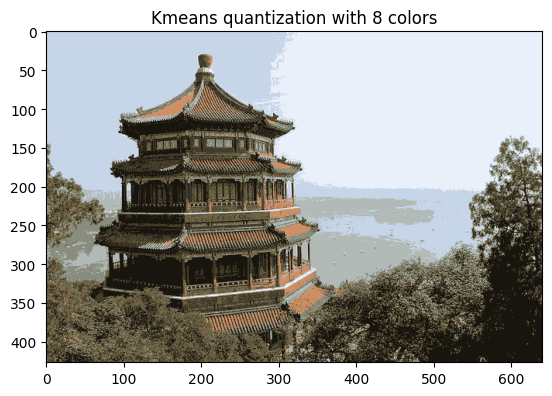

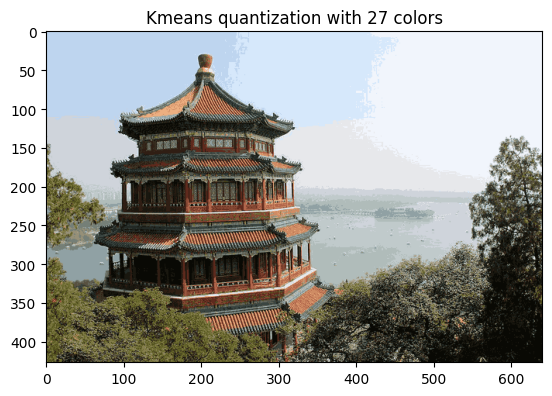

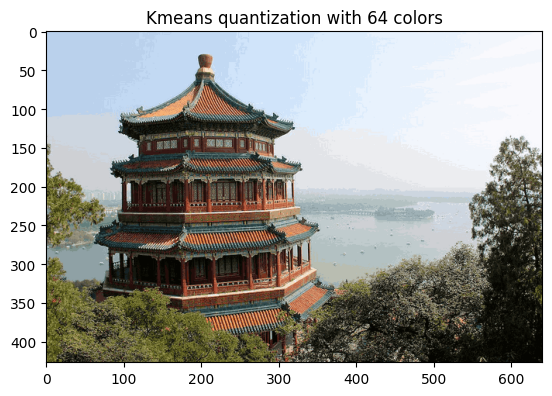

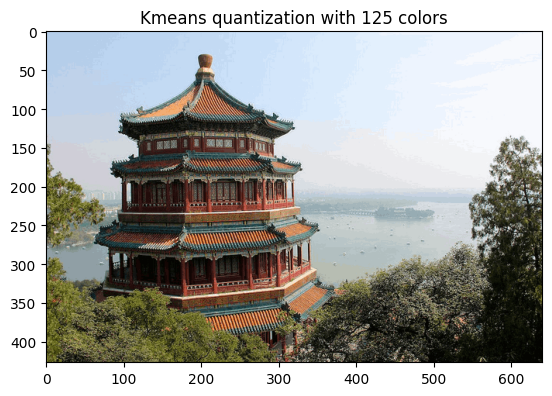

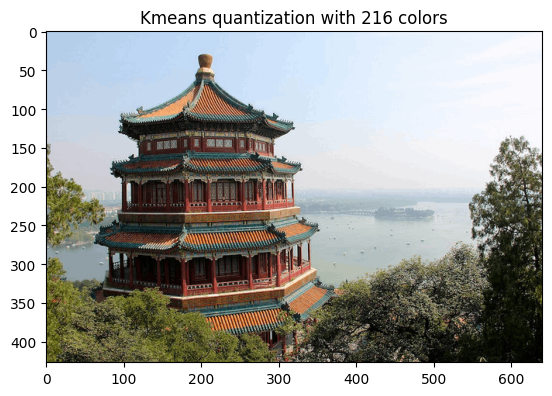

In [31]:
plot_images(china_imgs_kmeans_f, ks, 'Kmeans')

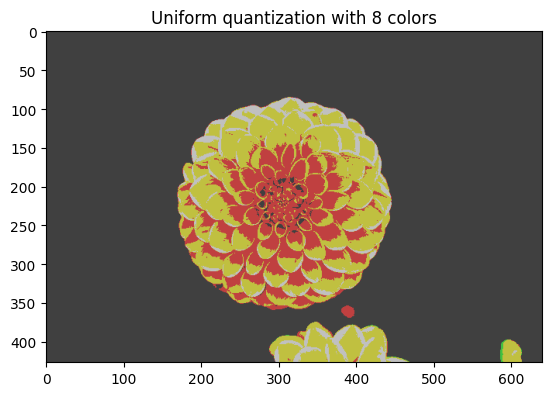

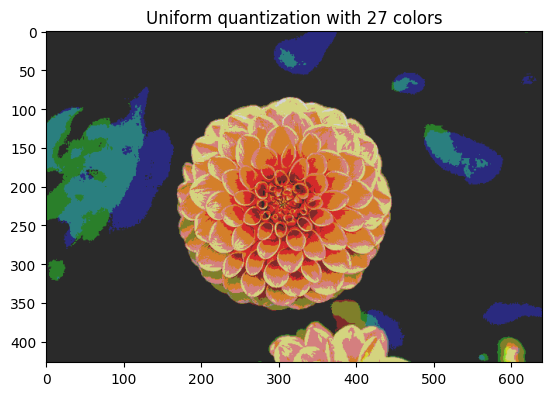

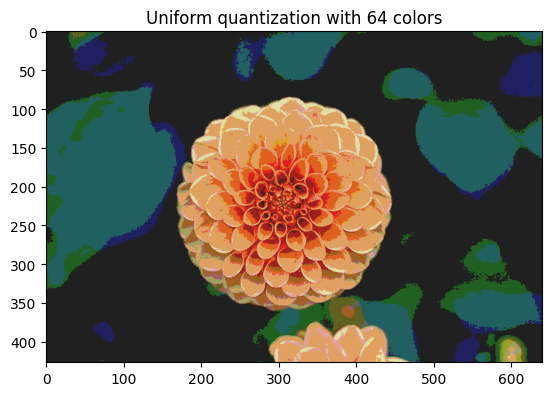

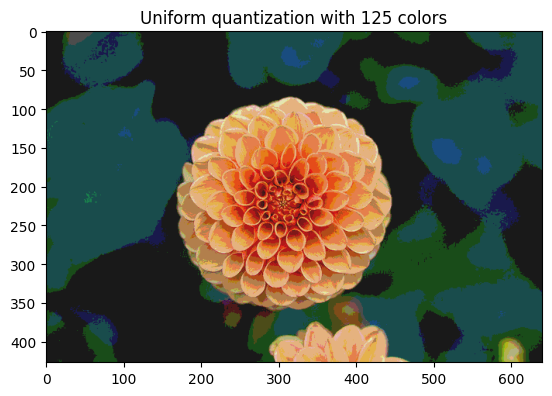

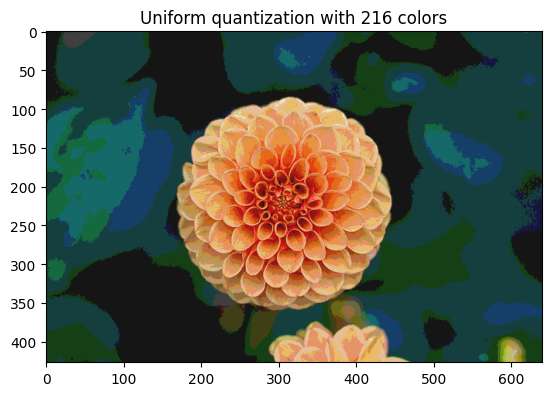

In [32]:
plot_images(flower_imgs_uni_f, ks, 'Uniform')

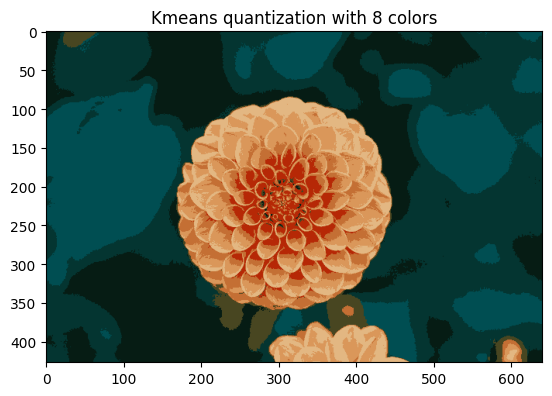

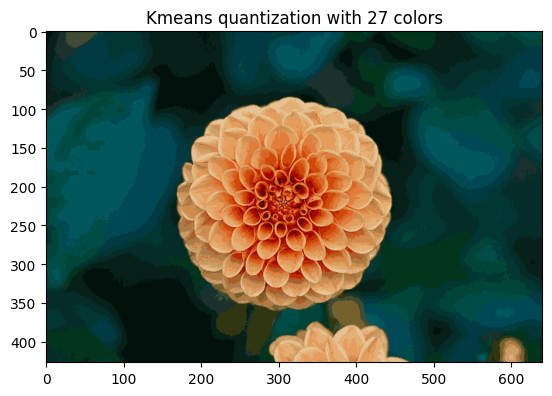

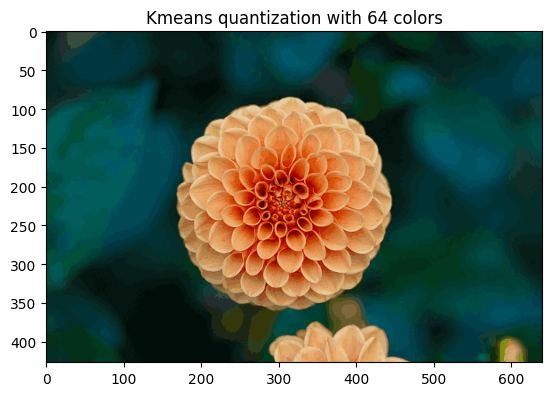

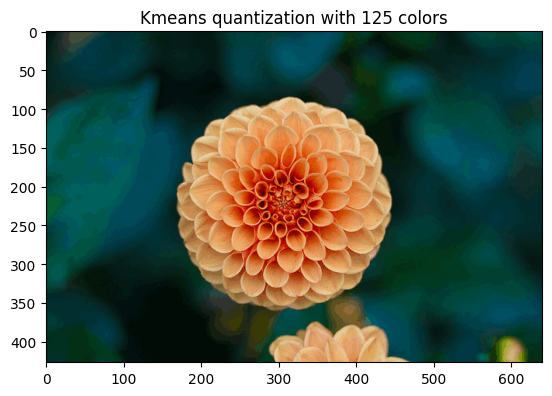

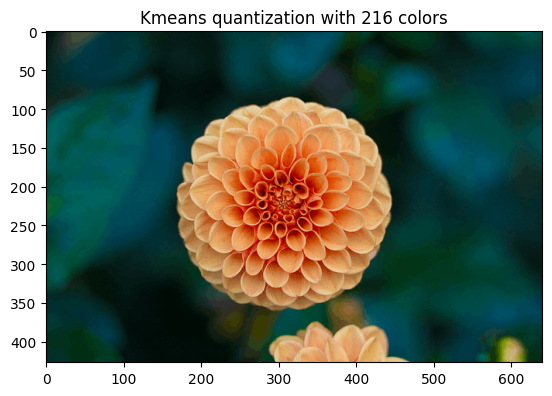

In [33]:
plot_images(flower_imgs_kmeans_f, ks, 'Kmeans')

## Inércia da quantização com kmeans

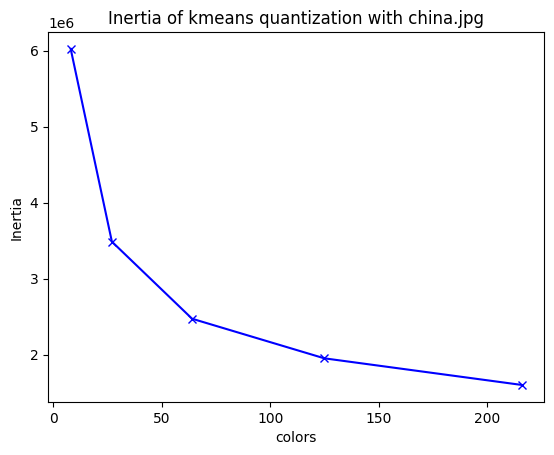

In [34]:
plot_inertias(china_inertias, ks, 'Inertia of kmeans quantization with china.jpg')

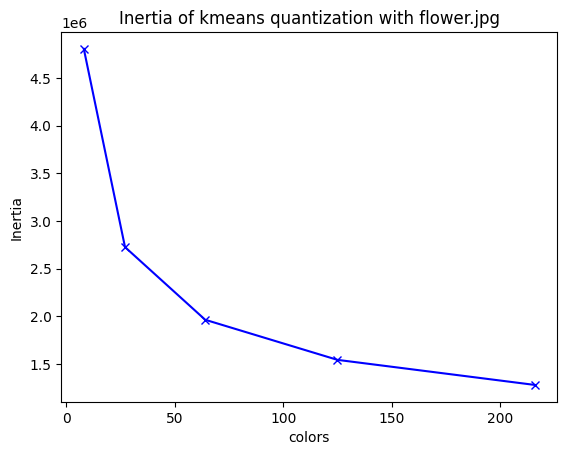

In [35]:
plot_inertias(flower_inertias, ks, 'Inertia of kmeans quantization with flower.jpg')

## MSE de ambas estratégias

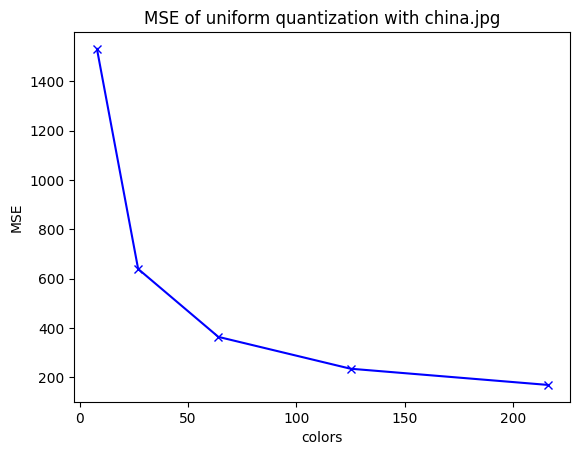

In [36]:
calc_and_plot_mse(img_china, china_imgs_uni_f, ks, 'MSE of uniform quantization with china.jpg')

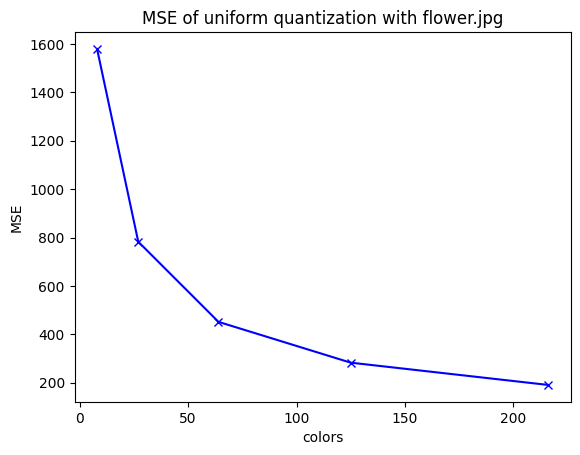

In [37]:
calc_and_plot_mse(img_flower, flower_imgs_uni_f, ks, 'MSE of uniform quantization with flower.jpg')

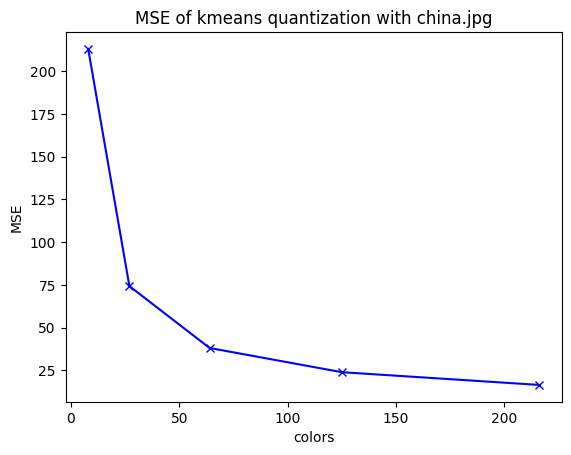

In [38]:
calc_and_plot_mse(img_china, china_imgs_kmeans_f, ks, 'MSE of kmeans quantization with china.jpg')

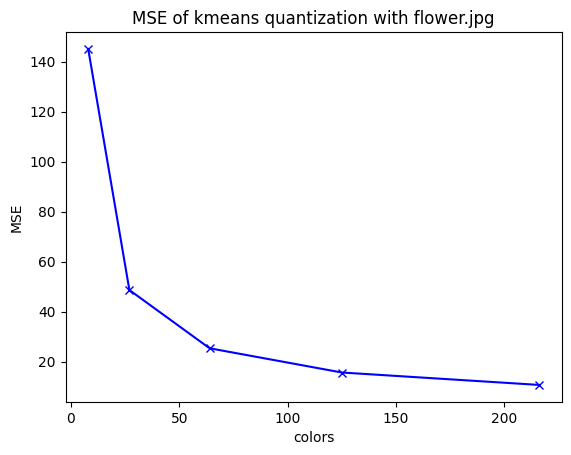

In [39]:
calc_and_plot_mse(img_flower, flower_imgs_kmeans_f, ks, 'MSE of kmeans quantization with flower.jpg')

A quantização por kmeans teve MSEs uma ordem de grandeza menores que os MSEs da quantização uniforme. Isso é factível com as imagens plotadas, visto que a quantização com kmeans gerou imagens mais parecidas, visualmente, com a imagem original utilizando menos cores que a quantização uniforme.

## Tamanho das imagens

<class 'list'>


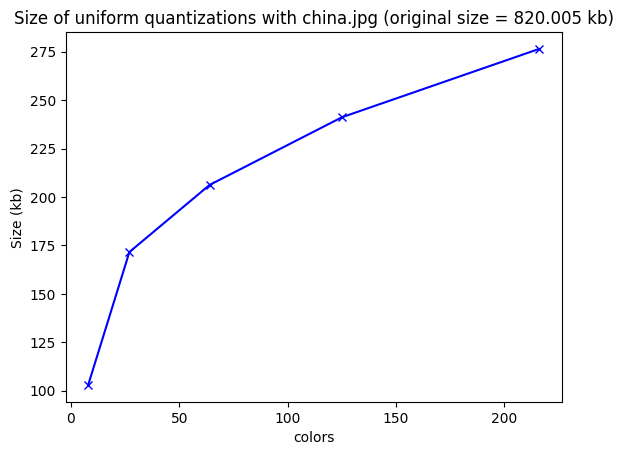

In [40]:
calc_and_plot_size(img_china, china_imgs_uni_f, ks, 'Size of uniform quantizations with china.jpg')

<class 'list'>


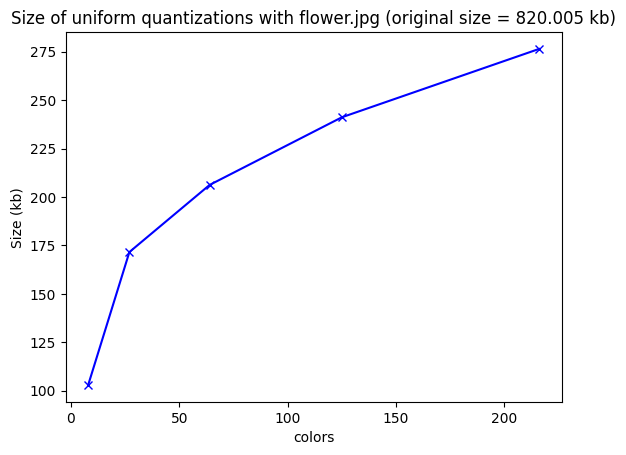

In [41]:
calc_and_plot_size(img_flower, flower_imgs_uni_f, ks, 'Size of uniform quantizations with flower.jpg')

<class 'list'>


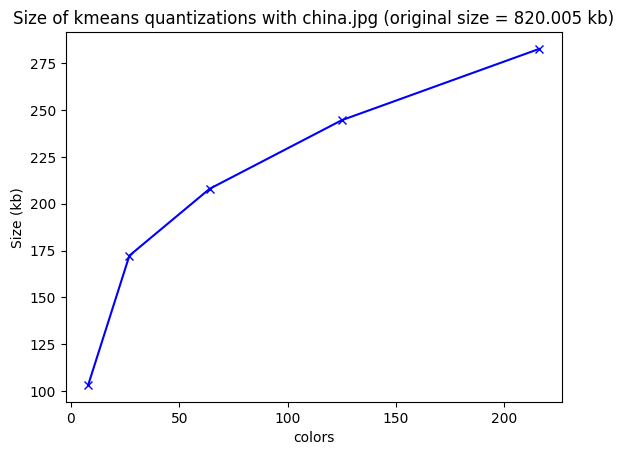

In [42]:
calc_and_plot_size(img_china, china_imgs_kmeans_f, ks, 'Size of kmeans quantizations with china.jpg')

<class 'list'>


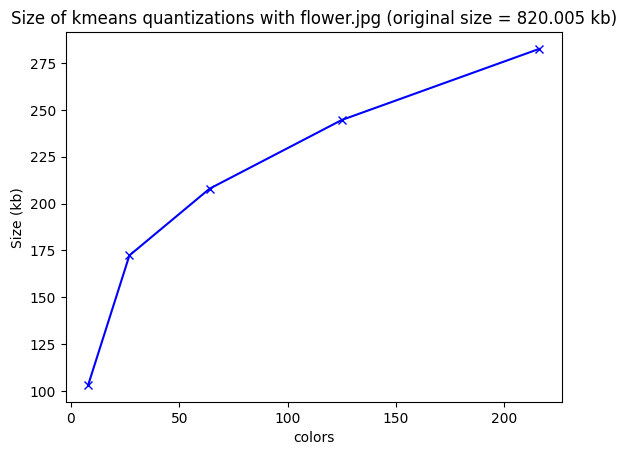

In [43]:
calc_and_plot_size(img_flower, flower_imgs_kmeans_f, ks, 'Size of kmeans quantizations with flower.jpg')

O tamanho das imagens geradas, quando comparadas entre números de cores iguais, não diferenciaram entre o método de quantização, já que o armazenamento de ambos é feito da mesma forma.